# Cphase gate simulation in spin qubit
Author: Jiheng Duan

Email: jiheng.duan@rochester.edu

In [1]:
import sys
# This on is a path correcting code, which is used to find the path of QuSim.
sys.path.append('../../..')
import QuSim.DataPlot.plot_lib as pl
import QuSim.Instruments.tools as tools
import QuSim.Instruments.stochastic_gen as sg
import QuSim.System.arb_qubit_system as aqs
import QuSim.Instruments.angle as  ang
from QuSim.Instruments.angle import get_angle

import numpy as np
import matplotlib.pyplot as plt

from tqdm import *
from time import *
from sympy import*
import copy
import pickle
from qutip import*

def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

## Logic qubit case
### Define system

We start from logic qubit.

Referring to https://journals.aps.org/prb/pdf/10.1103/PhysRevB.90.045418

The effective Hamiltonian for two qubit is given by
$$
H_{eff} = (\mu \Delta_{12} + \bar{B}) \sigma_z^1 + (\mu \Delta_{34} + \bar{B}) \sigma_z^2 + J_{23}/4 (\sigma_z^1 \sigma_z^2 - II)
$$

Here, we reduce this to 

$$
H_{eff} = \omega_1 \sigma_z^1 + \omega_2 \sigma_z^2 + J_{12}\sigma_x^1 + J_{34}\sigma_x^2 +  \chi \sigma_z^1 \sigma_z^2
$$


In [2]:
int_strength = 0.2e-3 # 0.2MHz
freq_list = [
    [0, 0.3],
    [0, 0.4]
]

inter_list = [
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
]

r_dic = {
    "r12": int_strength
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list = [
    {
        "v01": 2e-3
    },
    {
        "v01": 3.1e-3
    }
]

## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

# gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_00, E_00, index_00 = _system_arb1.get_eigenstates_energy((0,0))
state_01, E_01, index_01 = _system_arb1.get_eigenstates_energy((0,1))
state_10, E_10, index_10 = _system_arb1.get_eigenstates_energy((1,0))
state_11, E_11, index_11 = _system_arb1.get_eigenstates_energy((1,1))

_system_arb1.H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1.25663706e-03 1.94778745e-02 1.25663706e-02 0.00000000e+00]
 [1.94778745e-02 2.51201749e+00 0.00000000e+00 1.25663706e-02]
 [1.25663706e-02 0.00000000e+00 1.88369896e+00 1.94778745e-02]
 [0.00000000e+00 1.25663706e-02 1.94778745e-02 4.39948635e+00]]

In [13]:
t_width = 10; bisa_amp = 20e-3

simulation_option = {
    "simulation_time": 111, # ns
    "simulation_step": 10000,
    "initial_state": [state_00, state_01, state_10, state_11] # Do multiple simulation
}

noise_chan1 = [
    {
    'type': 'white',
    'switch': 'on',
    'std': bisa_amp*0.3,
    }
]
noise_chan2 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.3,
    'alpha': 0.9,
    }
]
noise_chan3 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.12,
    'alpha': 0.92,
    }
]
noise_chan4 = [
    {
    'type': 'gaussian',
    'switch': 'on',
    'mean': 0,
    'std': 0.2
    }
]
noise_chan5 = [
    {
    'type': 'gaussian',
    'switch': 'on',
    'mean':0,
    'std': 0.1
    }
]

pulse_sequence = [
    {
        'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': (0,1),
        'noise': noise_chan1
    },
    {
        'pulse_index': 1,
        'type': "Z",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': 0,
        'noise': noise_chan2
    },
    {
        'pulse_index': 2,
        'type': "Z",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': 1,
        'noise': noise_chan3
    },
    {
        'pulse_index': 3,
        'type': "XY",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': 0,
        'noise': noise_chan4
    },
    {
        'pulse_index': 4,
        'type': "XY",
        "pulse_shape": "square",
        't_delay': 0, # unit in ns
        't_width': 0, # unit in ns
        't_plateau':simulation_option['simulation_time'], # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': 1,
        'noise': noise_chan5
    }
]

%matplotlib qt
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

0

In [14]:
result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
propa_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence)
angle_list

25.0%. Run time:   2.56s. Est. time left: 00:00:00:07
50.0%. Run time:   2.69s. Est. time left: 00:00:00:02
75.0%. Run time:   2.83s. Est. time left: 00:00:00:00
100.0%. Run time:   2.88s. Est. time left: 00:00:00:00
Total run time:   2.93s


[array([[5.44985642]]),
 array([[4.64543443]]),
 array([[5.30954668]]),
 array([[0.97249432]])]

In [15]:
U = propa_list[-1]
Usim = U/U.data[0,0]
Usim

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.00000000e+00j  0.0580983 -7.69386361e-02j
   0.20786679-8.04002771e-02j  0.00457799+1.69915876e-05j]
 [-0.09318989-1.47834629e-02j  0.70745082-7.37202399e-01j
  -0.01492055+1.94477854e-02j  0.00759542+7.39803660e-02j]
 [-0.21368842-5.90354968e-02j  0.00420821+5.15719305e-03j
   0.99194472-1.01986219e-01j -0.12043201-3.06153004e-02j]
 [ 0.01541099-2.64522214e-02j -0.06919401+3.01153476e-02j
   0.00889986+1.19497622e-01j -0.29148612+9.76233061e-01j]]

In [16]:
# Construct a decoupled system
r_dic = {
    "r12": 0
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength
extra_list=None
_system_arb2 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_00, E_00, index_00 = _system_arb2.get_eigenstates_energy((0,0))
state_01, E_01, index_01 = _system_arb2.get_eigenstates_energy((0,1))
state_10, E_10, index_10 = _system_arb2.get_eigenstates_energy((1,0))
state_11, E_11, index_11 = _system_arb2.get_eigenstates_energy((1,1))
simulation_option2 = copy.deepcopy(simulation_option)
simulation_option2['initial_state'] = [state_00, state_01, state_10, state_11]
# simulation_option2['simulation_time'] = 154
pulse_sequence2 = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option2['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (0,1)
    }
]

result_list2, angle_list2 = _system_arb2.system_dynamics_mesolve(simulation_option2, pulse_sequence2)
angle_list2

[array([[0.]]),
 array([[3.7699635]]),
 array([[4.39828178]]),
 array([[1.88501191]])]

In [17]:
q_pmatrix = np.array([[1,0,0,0], 
              [0, np.exp(-1j*angle_list2[1][0][0]), 0, 0],
              [0,0, np.exp(-1j*angle_list2[2][0][0]), 0],
              [0,0,0, np.exp(-1j *angle_list2[3][0][0])]])
# single qubit rotation correcting phase gate during ZZ inter
q_phase_gate = Qobj(q_pmatrix,
              dims = [[2,2], [2,2]])
q_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.80898624+0.58782757j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.30896748+0.9510726j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.30907055-0.95103911j]]

In [18]:
# Correcting single qubit phase during ZZ inter
Usim_p = Usim * q_phase_gate
Usim_p

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j         -0.00177408+0.09639408j  0.01224242+0.22253748j
  -0.00139876-0.0043591j ]
 [-0.09318989-0.01478346j -0.13897008+1.0122457j  -0.01388629-0.02019926j
   0.0680107 -0.03008869j]
 [-0.21368842-0.0590355j  -0.00643592-0.0016984j  -0.20948236+0.97492188j
   0.00810564+0.12399784j]
 [ 0.01541099-0.02645222j  0.03827437-0.06503705j -0.11640068-0.02845647j
   1.0185256 -0.02451019j]]

In [19]:
# Phase gate after ZZ inter, correcting single qubit phase
phi12 = -np.angle(Usim_p.data[1,1])
c_pmatrix = np.array([[1,0,0,0], 
              [0, np.exp(1j*phi12), 0, 0],
              [0,0, np.exp(1j*phi12), 0],
              [0,0,0, np.exp(1j *2*phi12)]])
# correcting phase gate
c_phase_gate = Qobj(c_pmatrix,
              dims = [[2,2], [2,2]])
c_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13601307-0.99070704j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.13601307-0.99070704j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.96300089+0.26949821j]]

In [20]:
Uphase = Usim_p * c_phase_gate
Uphase

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.j          9.57395942e-02-0.01135327j
   2.18804317e-01-0.04239666j  2.52177950e-03+0.00382085j]
 [-9.31898936e-02-0.01478346j  1.02174069e+00+0.j
  -1.81228326e-02+0.01650461j -5.73855167e-02+0.0473042j ]
 [-2.13688423e-01-0.0590355j  -8.07246633e-04+0.00660712j
   9.94354307e-01+0.07493354j -4.12229317e-02-0.11722557j]
 [ 1.54109863e-02-0.02645222j -6.96384749e-02-0.0290728j
  -1.23600087e-02+0.11918943j -9.74235610e-01+0.29809416j]]

#### Cal ideal Uphase

In [21]:
Uphase_ideal_matrix = np.array([[1,0,0,0], 
              [0, 1, 0, 0],
              [0,0, 1, 0],
              [0,0,0, np.exp(1j*2*phi12)]])
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.96300089+0.26949821j]]

In [22]:
pickle.dump(Uphase_ideal_matrix, open('../../../Data/Uphase_ideal.pkl', 'wb'))

#### Load ideal Uphase and cal fidelity

In [23]:
Uphase_ideal_matrix = pickle.load(open('../../../Data/Uphase_ideal.pkl', 'rb'))
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.96300089+0.26949821j]]

In [24]:
f = (1/4*(Uphase_ideal*Uphase.dag()).tr())
f = abs(f)
print('Fidelity:{: .10%}'.format(f))##### fidelity

Fidelity: 100.8733918711%


In [55]:
Uphase

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j         -0.04292607+0.00775256j -0.08833023+0.15147564j
   0.0088594 -0.00788683j]
 [ 0.04410601+0.00964278j  0.99784837+0.j          0.00801811-0.01237505j
  -0.0177106 -0.18580702j]
 [ 0.08671428+0.1523959j  -0.01484529+0.00155633j  0.99516605+0.00985924j
  -0.10663105+0.00122122j]
 [-0.00263655+0.0010269j   0.07986761+0.16906934j -0.09194397+0.0540306j
  -0.85672004+0.50246463j]]

## Physical spin case
### Define system

* Single spin freq
$\omega_i = g\mu_B B_i$
here, $g=2$, $omega_i = [0, 15, 25, 28]$ MHz. Good case: $omega_i = [0, 150, 250, 350]$ MHz .

* Static coupling
$J_{ij} \approx 0.5\sim 1MHz$

* Bias amp: $J_{23} = 20 \sim 100 MHz$


In [3]:
freq_list = [ # GHz
    [0, 10.028],
    [0, 10],
    [0, 10.025],
    [0, 10.015]
]

inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
    ,
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }],
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }],
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]

r_dic = {
    "r12": 5e-3,
    "r23": 4e-3,
    "r34": 2e-3
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list=None
## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

# gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_0000, E_0000, _= _system_arb1.get_eigenstates_energy((0,0,0,0))

state_0001, E_0001, _= _system_arb1.get_eigenstates_energy((0,0,0,1))
state_0010, E_0010, _= _system_arb1.get_eigenstates_energy((0,0,1,0))
state_0100, E_0100, _= _system_arb1.get_eigenstates_energy((0,1,0,0))
state_1000, E_1000, _= _system_arb1.get_eigenstates_energy((1,0,0,0))

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))

"""leakage"""
state_0011, E_0011, index_0011= _system_arb1.get_eigenstates_energy((0,0,1,1))
state_1100, E_1100, index_1100= _system_arb1.get_eigenstates_energy((1,1,0,0))

state_0111, E_0111, _= _system_arb1.get_eigenstates_energy((0,1,1,1))
state_1011, E_1011, _= _system_arb1.get_eigenstates_energy((1,0,1,1))
state_1101, E_1101, _= _system_arb1.get_eigenstates_energy((1,1,0,1))
state_1110, E_1110, _= _system_arb1.get_eigenstates_energy((1,1,1,0))

state_1111, E_1111, _= _system_arb1.get_eigenstates_energy((1,1,1,1))

_system_arb1.H

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[6.91150384e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.29700831e+01 2.51327412e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.51327412e-02 6.29826495e+01 0.00000000e+00
  5.02654825e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.25933883e+02
  0.00000000e+00 5.02654825e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.

### Energy level



#### $\omega_2$ scan

In [19]:
num_level = 16 # Num of level we want to see
w2_scan_space= np.linspace(9, 12, 800)
w =copy.deepcopy(freq_list)

energy_level_list = []
for w2 in w2_scan_space:
    dummy_list = []
    w[1][1] = w2
    _system_arb1 = aqs.arb_qubit_system(w, inter_list, r, extra_list, gamma_list, driving_list, bias_list)
    for j in range(0,num_level):
        dummy_list.append((_system_arb1.H.eigenenergies()[j] / np.pi/2).real)
    energy_level_list.append(dummy_list)

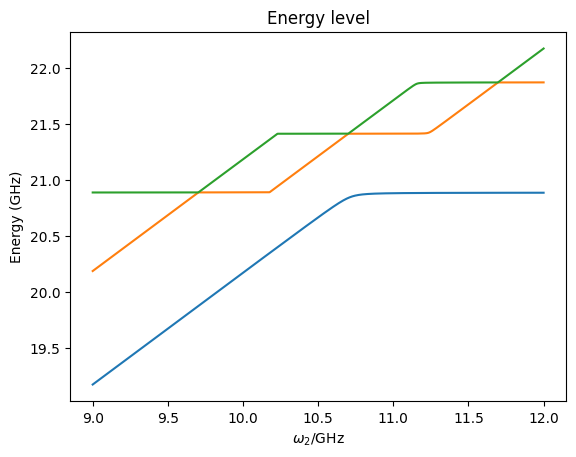

0

In [20]:
%matplotlib inline
pl.plot_Elevel_dynamics(w2_scan_space, energy_level_list, [index_0101, index_1100, index_0011], "\omega_2")

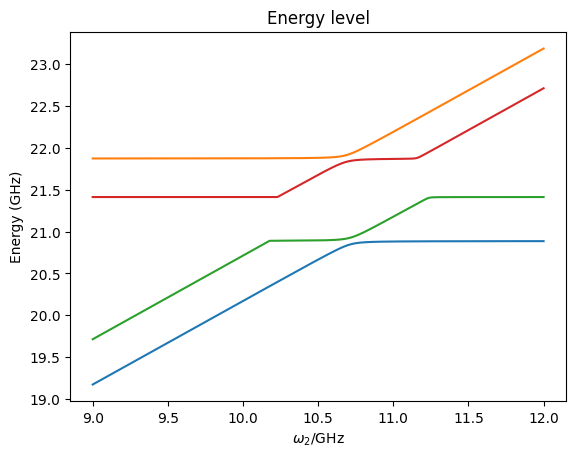

0

In [21]:
# %matplotlib qt
pl.plot_Elevel_dynamics(w2_scan_space, energy_level_list, [index_0101, index_1010, index_0110, index_1001], "\omega_2")

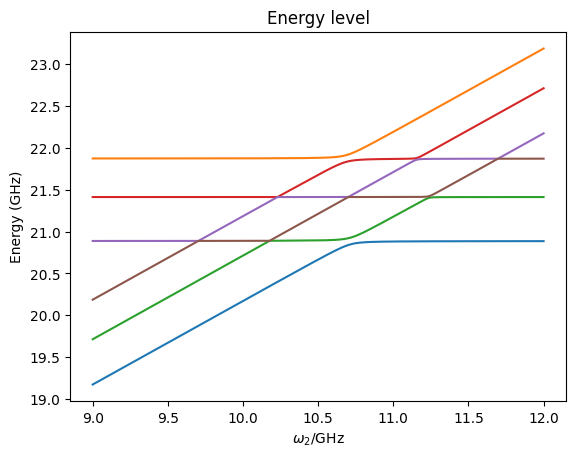

0

In [22]:
# %matplotlib qt
pl.plot_Elevel_dynamics(w2_scan_space, energy_level_list, [index_0101, index_1010, index_0110, index_1001, index_0011, index_1100], "\omega_2")

#### $J_{23}$ scan

In [5]:
num_level = 16 # Num of level we want to see
j23_scan_space= np.linspace(0.01e-3, 300e-3, 1000)
j_dic =copy.deepcopy(r_dic)

energy_level_list = []
for j23 in j23_scan_space:
    dummy_list = []
    j_dic["r23"] = j23
    j_matrix = tools.r2matrix(j_dic, freq_list)
    _system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, j_matrix, extra_list, gamma_list, driving_list, bias_list)
    for j in range(0,num_level):
        dummy_list.append((_system_arb1.H.eigenenergies()[j] / np.pi/2).real)
    energy_level_list.append(dummy_list)

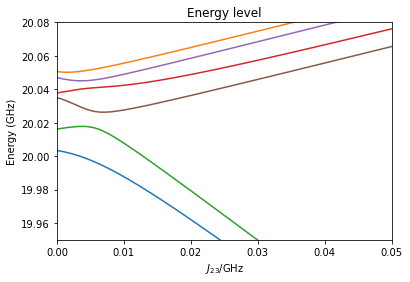

0

In [11]:
%matplotlib inline
pl.plot_Elevel_dynamics(j23_scan_space, energy_level_list, [index_0101, index_1010, index_0110, index_1001, index_0011, index_1100], "J_{23}", xrange=[0,50e-3], yrange=[19.95,20.08])

In [124]:
print(f'Subspace: E1010={E_1010}, E1001={E_1001}, E_0110={E_0110}, E0101={E_0101}')
print(f'Leakage space: E0011={E_0011}, E1100={E_1100}')

Subspace: E1010=21.874091354873737, E1001=21.41293137028615, E_0110=19.813061794275313, E0101=19.271933048307524
Leakage space: E0011=20.88798648225715, E1100=20.285996086616972


In [127]:
print(f'Subspace: index1010={index_1010}, index1001={index_1001}, Eindex0110={index_0110}, index0101={index_0101}')
print(f'Leakage space: index0011={index_0011}, index1100={index_1100}')

Subspace: index1010=10, index1001=9, Eindex0110=6, index0101=5
Leakage space: index0011=8, index1100=7


### System dynamics

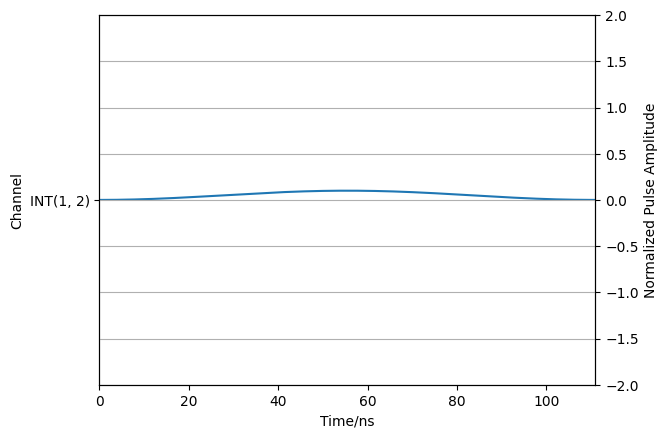

0

In [30]:
t_width = 111; bisa_amp = 100e-3

simulation_option = {
    "simulation_time": 111, # ns
    "simulation_step": 10000,
    "initial_state": [state_0101, state_0110, state_1001, state_1010] # Do multiple simulation
}

noise_chan1 = [
    {
    'type': 'white',
    'switch': 'off',
    'std': bisa_amp*0.3,
    }
]
noise_chan2 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.3,
    'alpha': 0.9,
    }
]
noise_chan3 = [
    {
    'type': '1/f',
    'switch': 'on',
    'scale': 0.12,
    'alpha': 0.92,
    }
]
noise_chan4 = [
    {
    'type': 'gaussian',
    'switch': 'on',
    'mean': 0,
    'std': 0.2
    }
]
noise_chan5 = [
    {
    'type': 'gaussian',
    'switch': 'on',
    'mean':0,
    'std': 0.1
    }
]

pulse_sequence = [
    {
        'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': (1,2),
        'noise': noise_chan1
    },
    # {
    #     'pulse_index': 1,
    #     'type': "Z",
    #     "pulse_shape": "square",
    #     't_delay': 0, # unit in ns
    #     't_width': 0, # unit in ns
    #     't_plateau':simulation_option['simulation_time'], # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'phase': 0, # unit in rad; Z pulse does not use it
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 0,
    #     'noise': noise_chan2
    # },
    # {
    #     'pulse_index': 2,
    #     'type': "Z",
    #     "pulse_shape": "square",
    #     't_delay': 0, # unit in ns
    #     't_width': 0, # unit in ns
    #     't_plateau':simulation_option['simulation_time'], # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'phase': 0, # unit in rad; Z pulse does not use it
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 1,
    #     'noise': noise_chan3
    # },
    # {
    #     'pulse_index': 3,
    #     'type': "XY",
    #     "pulse_shape": "square",
    #     't_delay': 0, # unit in ns
    #     't_width': 0, # unit in ns
    #     't_plateau':simulation_option['simulation_time'], # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'phase': 0, # unit in rad; Z pulse does not use it
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 0,
    #     'noise': noise_chan4
    # },
    # {
    #     'pulse_index': 4,
    #     'type': "XY",
    #     "pulse_shape": "square",
    #     't_delay': 0, # unit in ns
    #     't_width': 0, # unit in ns
    #     't_plateau':simulation_option['simulation_time'], # unit in ns
    #     'freq': 0, # unit in GHz; Z pulse does not use it
    #     'phase': 0, # unit in rad; Z pulse does not use it
    #     'amplitude': 0, # XY: Rabi freq; Z: biased frequency
    #     'q_index': 1,
    #     'noise': noise_chan5
    # }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [31]:
result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
propa_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence)
angle_list

12.5%. Run time:   4.27s. Est. time left: 00:00:00:29
25.0%. Run time:   4.77s. Est. time left: 00:00:00:14
31.2%. Run time:   5.01s. Est. time left: 00:00:00:11
43.8%. Run time:   5.13s. Est. time left: 00:00:00:06
50.0%. Run time:   5.36s. Est. time left: 00:00:00:05
62.5%. Run time:   5.48s. Est. time left: 00:00:00:03
75.0%. Run time:   5.80s. Est. time left: 00:00:00:01
81.2%. Run time:   5.86s. Est. time left: 00:00:00:01
93.8%. Run time:   6.19s. Est. time left: 00:00:00:00
100.0%. Run time:   6.25s. Est. time left: 00:00:00:00
Total run time:   6.30s


[array([[2.22756723]]),
 array([[1.25061781]]),
 array([[3.86782499]]),
 array([[3.37248685]])]

In [32]:
state_0011.dag() * result_list[3].states[-1]
for i in range(4):
    print(f'state index {i} leakages to 0011: {state_0011.dag() * result_list[i].states[-1]}')
    print(f'state index {i} leakages to 1100: {state_1100.dag() * result_list[i].states[-1]}')

state index 0 leakages to 0011: Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[7.75325618e-07-4.20229028e-07j]]
state index 0 leakages to 1100: Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[1.61327384e-11-3.04895737e-11j]]
state index 1 leakages to 0011: Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[4.29789445e-09-6.48023637e-09j]]
state index 1 leakages to 1100: Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[1.78027234e-10+8.77768095e-08j]]
state index 2 leakages to 0011: Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[-4.56602061e-08-1.53141551e-08j]]
state index 2 leakages to 1100: Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[6.61081253e-09-1.78895183e-09j]]
state index 3 leakages to 0011: Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[-3.56965079e-11-2.72142564e-12j]]
state index

In [33]:
U = propa_list[-1] # get the Unitary 

# Perform partial trace, tracing out the coupler degree of freedom
slist = [
    state_0101, state_0110, state_1001, state_1010
]
sdlist = [
    state_0101.dag(), state_0110.dag(), state_1001.dag(), state_1010.dag()
]
dims = [len(sdlist), len(slist)];   umatrix = []
for i in range(dims[0]):
    umatrix_row = []
    for j in range(dims[1]):
        umatrix_row.append(sdlist[i] * U * slist[j])
    umatrix.append(umatrix_row)

Usim = Qobj(np.array(umatrix).reshape(dims[0],dims[1]), dims = [[int(np.sqrt(dims[0])), int(np.sqrt(dims[0]))], [int(np.sqrt(dims[1])), int(np.sqrt(dims[1]))]])
Usim = Usim/Usim.data[0,0]
Usim

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j -4.17889794e-07-3.08655343e-07j
  -6.08799968e-07-3.04987167e-07j -8.91439477e-10-2.39081217e-10j]
 [-4.57526949e-07+6.99920621e-08j  5.59553328e-01-8.28794312e-01j
   6.07467893e-11+3.46474043e-10j -6.20110341e-07+2.57590940e-07j]
 [ 6.68603429e-07-1.09598532e-06j -4.72581586e-10-3.16312340e-10j
  -6.94060741e-02+9.97588471e-01j  1.59476323e-07-1.69106893e-07j]
 [-4.94323164e-10-1.91275688e-09j  2.12987693e-07-1.18000388e-06j
   5.59906514e-08-3.43027915e-07j  4.13119392e-01+9.10676816e-01j]]

In [34]:
# Construct a decoupled system
r_dic = {
    "r12": 0,
    "r23": 0,
    "r34": 0
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength
extra_list=None
_system_arb2 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))
simulation_option2 = copy.deepcopy(simulation_option)
simulation_option2['initial_state'] = [state_0101, state_0110, state_1001, state_1010]
# simulation_option2['simulation_time'] = 154
pulse_sequence2 = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option2['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0, # XY: Rabi freq; Z: biased frequency
        'q_index': (1,2)
    }
]

print(f'Subspace: index1010={index_1010}, index1001={index_1001}, Eindex0110={index_0110}, index0101={index_0101}')
print(f'Leakage space: index0011={index_0011}, index1100={index_1100}')

result_list2, angle_list2 = _system_arb2.system_dynamics_mesolve(simulation_option2, pulse_sequence2)
angle_list2

Subspace: index1010=10, index1001=9, Eindex0110=6, index0101=5
Leakage space: index0011=8, index1100=7


[array([[4.39795206]]),
 array([[1.25630764]]),
 array([[3.76949966]]),
 array([[0.62791785]])]

In [35]:
q_pmatrix = np.array([[np.exp(-1j*angle_list2[0][0][0]),0,0,0], 
              [0, np.exp(-1j*angle_list2[1][0][0]), 0, 0],
              [0,0, np.exp(-1j*angle_list2[2][0][0]), 0],
              [0,0,0, np.exp(-1j *angle_list2[3][0][0])]])
# single qubit rotation correcting phase gate during ZZ inter
q_phase_gate = Qobj(q_pmatrix,
              dims = [[2,2], [2,2]])
q_phase_gate = q_phase_gate/q_phase_gate.data[0,0]
q_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j -1.        -5.17653959e-05j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.8089383 +5.87893548e-01j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j -0.80894468-5.87884776e-01j]]

In [36]:
Usim_p = Usim * q_phase_gate
Usim_p

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  4.17873816e-07+3.08676974e-07j
  -3.13181625e-07-6.04625374e-07j  5.80573012e-10+7.17467175e-10j]
 [-4.57526949e-07+6.99920621e-08j -5.59596230e-01+8.28765346e-01j
  -1.54549450e-10+3.15988770e-10j  6.53068751e-07+1.56176609e-07j]
 [ 6.68603429e-07-1.09598532e-06j  4.72565211e-10+3.16336803e-10j
  -6.42621057e-01+7.66184141e-01j -2.28422890e-07+4.30444185e-08j]
 [-4.94323164e-10-1.91275688e-09j -2.13048776e-07+1.17999285e-06j
   2.46956880e-07-2.44571876e-07j  2.01182302e-01-9.79553764e-01j]]

In [37]:
# Phase gate after ZZ inter, correcting single qubit phase
phi12 = -np.angle(Usim_p.data[1,1])
c_pmatrix = np.array([[1,0,0,0], 
              [0, np.exp(1j*phi12), 0, 0],
              [0,0, np.exp(1j*phi12), 0],
              [0,0,0, np.exp(1j *2*phi12)]])
# correcting phase gate
c_phase_gate = Qobj(c_pmatrix,
              dims = [[2,2], [2,2]])
c_phase_gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.55959625-0.82876537j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.55959625-0.82876537j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.37370408+0.92754798j]]

In [38]:
Uphase = Usim_p * c_phase_gate
Uphase

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  2.19801681e-08-5.19053824e-07j
  -3.25837311e-07+5.97900176e-07j -8.82447734e-10+2.70388915e-10j]
 [-4.57526949e-07+6.99920621e-08j  9.99999970e-01+0.00000000e+00j
   3.48365842e-10-4.87408975e-11j -3.88915755e-07+5.47388767e-07j]
 [ 6.68603429e-07-1.09598532e-06j -2.27673065e-12-5.68666571e-10j
   9.94595216e-01+1.03828309e-01j  4.54368026e-08-2.27959066e-07j]
 [-4.94323164e-10-1.91275688e-09j  1.09715851e-06-4.83752124e-07j
  -3.40888845e-07-6.78078063e-08j  8.33400470e-01+5.52669477e-01j]]

#### Cal ideal Cphase

In [39]:
Uphase_ideal_matrix = np.array([[1,0,0,0], 
              [0, 1, 0, 0],
              [0,0, 1, 0],
              [0,0,0, np.exp(1j*2*phi12)]])
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.37370408+0.92754798j]]

In [151]:
pickle.dump(Uphase_ideal_matrix, open('../../../Data/Uphase_ideal_4spin.pkl', 'wb'))

#### Load ideal Uphase and calculate fidelity

In [174]:
Uphase_ideal_matrix = pickle.load(open('../../../Data/Uphase_ideal_4spin.pkl', 'rb'))
Uphase_ideal = Qobj(Uphase_ideal_matrix, dims= [[2,2], [2,2]])
Uphase_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         1.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         1.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.85793813+0.51375303j]]

In [40]:
f = (1/4*(Uphase_ideal*Uphase.dag()).tr())
f = abs(f)
print('Fidelity:{: .10%}'.format(f))##### fidelity

Fidelity: 82.8397882236%
